In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
from sklearn import preprocessing
import math
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

ASISO method

In [2]:
#使用lof算法剔除余数利群点
def lof_sample(input,k,p):
    remainder_samples = input.shape[0]%k
    if remainder_samples == 0:
        return list(range(0,input.shape[0]))
    lof_model = LocalOutlierFactor(n_neighbors=10,p=p)
    lof_model.fit_predict(input)
    score = abs(lof_model.negative_outlier_factor_)
    return np.argsort(score)[:-remainder_samples]

#AMLI聚类
def subspace_division(input,output,k,p=2,lof=False,add_y=False):
    data = np.hstack((input,output))
    n_output = output.shape[1]
    if lof==True and add_y==False:
        lof_index = lof_sample(input,k,p)
        data = data[lof_index]
    elif lof==True and add_y==True:
        lof_index = lof_sample(data,k,p)
        data = data[lof_index]
    m = data.shape[0]
    if add_y == False:
        min_point = np.min(data[:,:-n_output],axis=0)#特征空间最小点
        ls = []
        for i in range(m):
            if i%k == 0:
                point_list = []
            distance_min = np.linalg.norm(data[:,:-n_output]-min_point,axis=1,ord=p)
            nearest_point = np.argmin(distance_min)
            point_list.append(data[nearest_point])
            data = np.delete(data,nearest_point,axis=0)
            min_point = np.mean(point_list,axis=0)[:-1]
            if len(point_list)==k or data.shape[0]==0:
                ls.append(point_list)
    else:
        min_point = np.min(data,axis=0)#特征空间最小点
        ls = []
        for i in range(m):
            if i%k == 0:
                point_list = []
            distance_min = np.linalg.norm(data-min_point,axis=1,ord=p)
            nearest_point = np.argmin(distance_min)
            point_list.append(data[nearest_point])
            data = np.delete(data,nearest_point,axis=0)
            min_point = np.mean(point_list,axis=0)
            if len(point_list)==k or data.shape[0]==0:
                ls.append(point_list)
    return ls

#簇心插值排序
def index_sort(input,output,k,p=2,lof=False,add_y=False):
    ls = subspace_division(input=input,output=output,k=k,p=p,lof=lof,add_y=add_y)
    data = np.hstack((input,output))
    n_output = output.shape[1]
    if add_y == True:
        cluster_mean = np.vstack((np.mean(ls[:-1],axis=1),np.mean(ls[-1],axis=0)))#每个簇的簇心
        min_point = np.min(data,axis=0)
        ls_sort = []
        for _ in range(cluster_mean.shape[0]):
            distance_min = np.linalg.norm(cluster_mean-min_point,axis=1,ord=p)
            nearest_cluster = np.argmin(distance_min)
            ls_sort.append(ls[nearest_cluster])
            min_point = cluster_mean[nearest_cluster,:]
            ls.pop(nearest_cluster)
            cluster_mean = np.delete(cluster_mean,nearest_cluster,axis=0)
    else:
        cluster_mean = np.vstack((np.mean(ls[:-1],axis=1)[:,:-n_output],np.mean(ls[-1],axis=0)[:-n_output]))#每个簇的簇心
        min_point = np.min(data[:,:-1],axis=0)
        ls_sort = []
        for _ in range(cluster_mean.shape[0]):
            distance_min = np.linalg.norm(cluster_mean-min_point,axis=1,ord=p)
            nearest_cluster = np.argmin(distance_min)
            ls_sort.append(ls[nearest_cluster])
            min_point = cluster_mean[nearest_cluster,:]
            ls.pop(nearest_cluster)
            cluster_mean = np.delete(cluster_mean,nearest_cluster,axis=0)
    return ls_sort

#AMLI插值
def ASISO_method(input,output,k=4,eta=1,p=2,lof=False,fit_method="linear",add_y=False):
    ls_sort = index_sort(input,output,k,p,lof,add_y)
    n_output = output.shape[1]
    model = LinearRegression() if fit_method == "linear" else SVR(kernel="rbf")
    point = []
    for i in range(0,len(ls_sort)):
        if i == len(ls_sort)-1:
            break
        cluster1 = np.array(ls_sort[i])
        cluster2 = np.array(ls_sort[i+1])
        x = np.vstack((cluster1,cluster2))[:,:-1]
        y = np.vstack((cluster1,cluster2))[:,-1]
        model.fit(x,y)
        pred1_sign_index = np.argsort(model.predict(cluster1[:,:-n_output])-cluster1[:,-n_output])
        pred2_sign_index = np.argsort(model.predict(cluster2[:,:-n_output])-cluster2[:,-n_output])
        for k in range(min(pred1_sign_index.shape[0],pred2_sign_index.shape[0])):
            if add_y == True:
                distance = np.linalg.norm(cluster1[pred1_sign_index[k]]-cluster2[pred2_sign_index[-k-1]],ord=p)
            else:
                distance = np.linalg.norm(cluster1[pred1_sign_index[k]][:-n_output]-cluster2[pred2_sign_index[-k-1]][:-n_output],ord=p)
            add_sample = np.linspace(cluster1[pred1_sign_index[k]],cluster2[pred2_sign_index[-k-1]],max(np.int(eta*distance),2))
            point.append(add_sample)
    sample = point[0]
    for i in range(len(point)):
        if i == len(point)-1:
            break
        sample = np.vstack((sample,point[i+1]))
    return sample

utils

In [3]:
#生成dataset
def generate_dataset(p,p1,n,per):
    w1 = np.random.randn(p,p1)
    w2 = np.random.normal(0,1,(p1,1))
    x = np.random.normal(0,1,(n,p))
    noise = np.vstack((np.random.normal(0,64,(np.int(per[0]*n),1)),np.random.uniform(-8,8,(np.int(per[1]*n),1)),np.random.normal(0,0.04,(np.int(per[2]*n),1))))
    y = tanh(x@w1)@w2+noise
    data = np.hstack((x,y))
    np.random.shuffle(data)
    return w1,w2,data[:,:-1],data[:,-1].reshape(-1,1)
#检验效果
def mse(w1,w2,x,y):
    erro = y-tanh(x@w1)@w2
    mse = np.sum(erro**2)/x.shape[0]
    return mse
def p_arfa(w1,w2,x,y,arfa):
    erro = y-tanh(tanh(x@w1)@w2)
    p = np.sum(np.abs(erro[:,0])>arfa)/x.shape[0]
    return p
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

Text(0.5, 1.0, 'processed data')

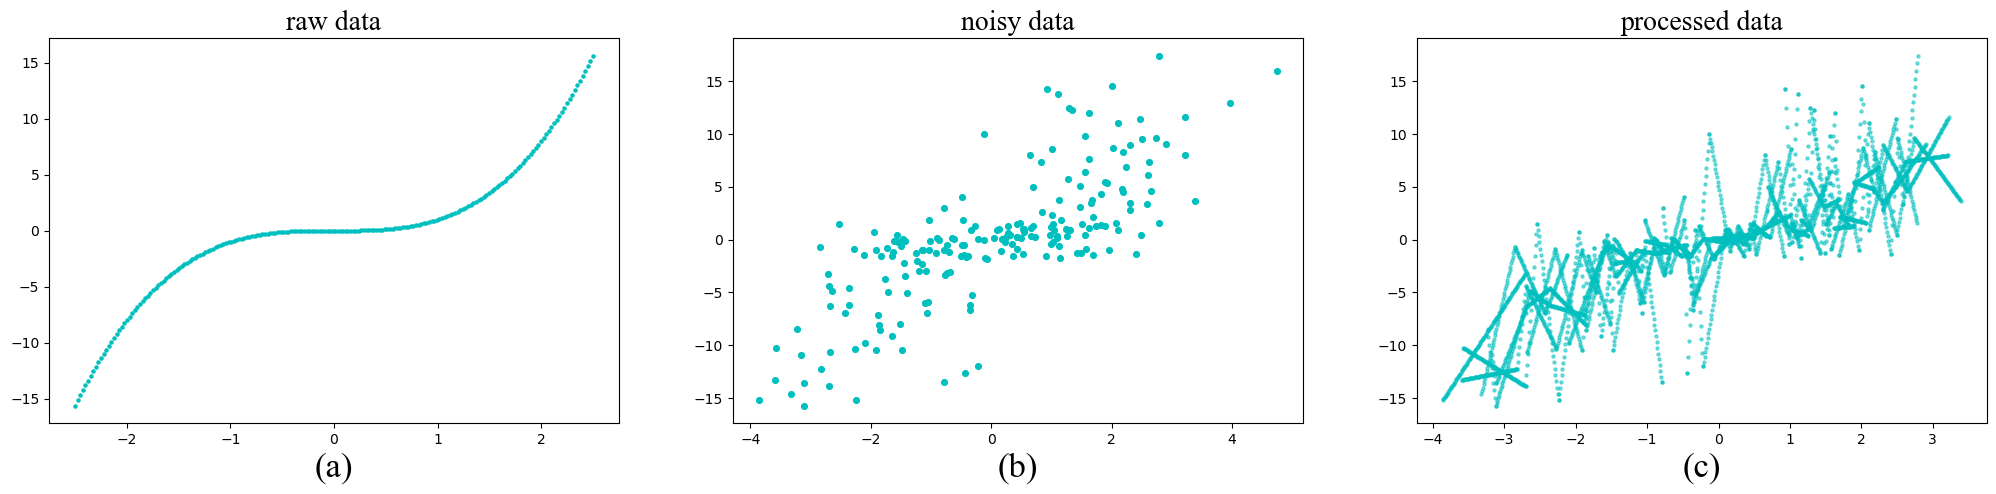

In [4]:
np.random.seed(124)
n = 200#sample size
x = np.linspace(2.5,-2.5,n)
y = x**3
x1 = x+np.random.randn(n)
x1 = x1.reshape(n,-1)
y1 = y+np.random.randn(n)
y = y.reshape(n,-1)
y1 = y1.reshape(n,-1)
sample = ASISO_method(x1,y1,6,100,p=2,lof=True,add_y=False,fit_method="linear")
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].scatter(x,y,color="c",s=5)
axes[0].set_xlabel("(a)",fontproperties='Times New Roman',size=25)
axes[0].set_title("raw data",size=20,fontproperties='Times New Roman')
axes[1].scatter(x1,y1,color="c",s=17,alpha=1)
axes[1].set_xlabel("(b)",fontproperties='Times New Roman',size=25)
axes[1].set_title("noisy data",size=20,fontproperties='Times New Roman')
axes[2].scatter(sample[:,:-1],sample[:,-1],color="c",s=5,alpha=0.5)
axes[2].set_xlabel("(c)",fontproperties='Times New Roman',size=25)
axes[2].set_title("processed data",size=20,fontproperties='Times New Roman')

experiment on artificial data sets

100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


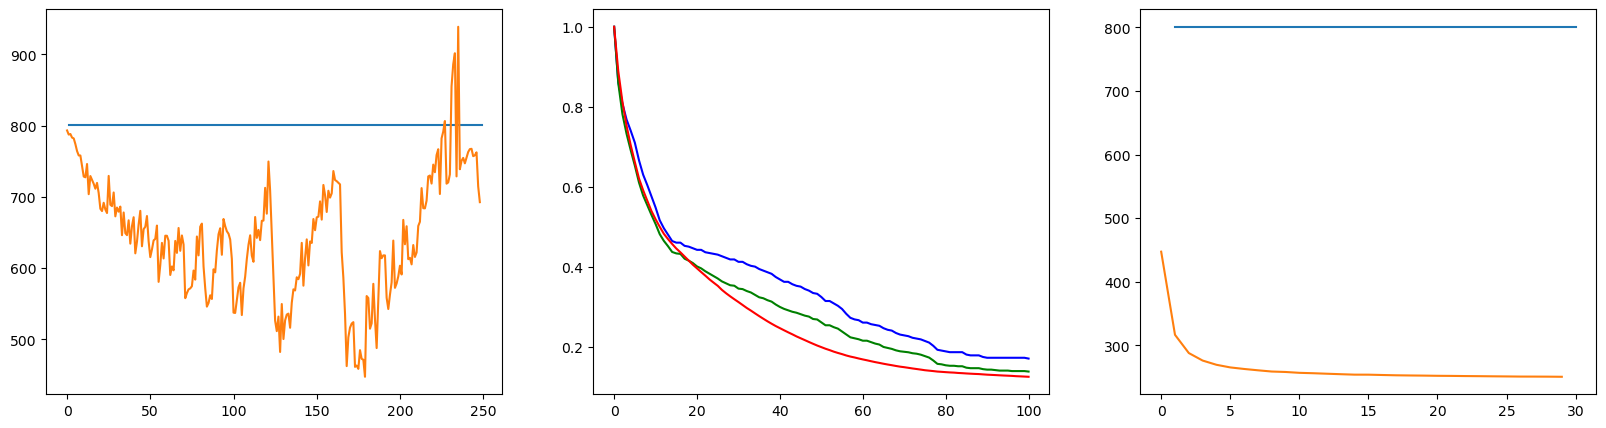

In [5]:
#Hyperparameter Selection
n = 500
n_subspace = 2
p_ = 5
p1_ = 3
repeat = 5
per = [0.2,0.3,0.5]
bf_mse_ls = []
af_mse_ls = []
bf_p1_ls = []
af_p1_ls = []
bf_p30_ls = []
af_p30_ls = []
bf_eta_mse_ls = []
af_eta_mse_ls = []
for k in tqdm(range(1,int(n/n_subspace))):
    np.random.seed(123)
    bf_ = []
    af_ = []
    for i in range(repeat):
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        bf = mse(w1,w2,x,y)
        data_AMLI = ASISO_method(x,y,k,1,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        af = mse(w1,w2,af_x,af_y)
        bf_.append(bf)
        af_.append(af)
    bf_mse_ls.append(np.mean(bf_))
    af_mse_ls.append(np.mean(af_))

min_k = np.argmin(af_mse_ls)+1
for eta in tqdm(range(1,31)):
    np.random.seed(123)
    bf_ = []
    af_ = []
    for i in range(repeat):
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        data_AMLI = ASISO_method(x,y,min_k,eta,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        bf = mse(w1,w2,x,y)
        af = mse(w1,w2,af_x,af_y)
        bf_.append(bf)
        af_.append(af)
    bf_eta_mse_ls.append(np.mean(bf_))
    af_eta_mse_ls.append(np.mean(af_))
    
    if eta == 1  or eta == 30:
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        data_AMLI = ASISO_method(x,y,min_k,eta,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        arfa = 0
        while arfa<=10:
            bf_p = p_arfa(w1,w2,x,y,arfa)
            af_p = p_arfa(w1,w2,af_x,af_y,arfa)
            arfa += 0.1
            if eta == 1:
                bf_p1_ls.append(bf_p)
                af_p1_ls.append(af_p)
            else:
                bf_p30_ls.append(bf_p)
                af_p30_ls.append(af_p)
                
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
axes[0].plot(range(1,int(n/n_subspace)),bf_mse_ls,af_mse_ls)
axes[1].plot(range(0,101,1),bf_p1_ls,c="b")
axes[1].plot(range(0,101,1),af_p1_ls,c="g")
axes[1].plot(range(0,101,1),af_p30_ls,c="r")
axes[2].plot(range(1,31,1),bf_eta_mse_ls,af_eta_mse_ls)

Save result

In [255]:
# save result
dic = {"K":range(1,int(n/n_subspace)),"befor":bf_mse_ls,"after":af_mse_ls}
dic2 = {"arfa X 0.1":range(0,101,1),"bf_p":bf_p1_ls,"af_p_eta1":af_p1_ls,"af_p_eta30":af_p30_ls}
dic3 = {"eta":range(1,31),"befor":bf_eta_mse_ls,"after":af_eta_mse_ls}
data = pd.DataFrame(dic)
data2 = pd.DataFrame(dic2)
data3 = pd.DataFrame(dic3)
data.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/k/6")
data2.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/p/6")
data3.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/eta/6")

Experiment on Benchmark Data Sets

In [847]:
np.random.seed(123)
add_noise = "Tru"
nomarlization = "True"
k =10#hyperparameters K
eta = 100#hyperparameters eta
train_data = pd.read_csv(r"/Users/dyk/Desktop/forestfires1.csv")
train_data = train_data.dropna(axis = 0)
x = train_data.iloc[:,:-1].values
y = train_data.iloc[:,-1].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=123)
if add_noise == "True":
    n = x_train.shape[0]
    per = [0.2,0.3,0.5]
    noise = np.hstack((np.random.normal(0,64,np.int(per[0]*n)+1),np.random.uniform(-8,8,np.int(per[1]*n)),np.random.normal(0,0.04,np.int(per[2]*n))))
    y_train = y_train+ noise
if nomarlization == "True":
    min_max_scaler = preprocessing.MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    y_train = min_max_scaler.fit_transform(y_train.reshape(-1,1))
    x_test = min_max_scaler.fit_transform(x_test)
    y_test = min_max_scaler.fit_transform(y_test.reshape(-1,1))
else:
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

data = ASISO_method(x_train,y_train,k,eta,p=2,lof=False,add_y=False,fit_method="SVR")
x_train_amli = data[:,:-1]
y_train_amli = data[:,-1].reshape(-1,1)
print(f"sample size:{x_train.shape[0]}\nafter ASISO:{x_train_amli.shape[0]}")

False
sample size:361
after AMLI v2:19572


In [612]:
#knn
from sklearn import neighbors
for k in range(1,140,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train,y_train)
    y_pred = modelKNN.predict(x_test)
    print("before AMLI , k:",(k),",  MAE:",(mean_absolute_error(y_pred,y_test)))
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train_amli,y_train_amli)
    y_pred = modelKNN.predict(x_test)
    print("after AMLI , k:",(k),",  MAE:",(mean_absolute_error(y_pred,y_test)))

before AMLI , k: 1 ,  MAE: 0.04062502395295469
before AMLI , k: 6 ,  MAE: 0.04198464137854572
before AMLI , k: 11 ,  MAE: 0.041986554825288847
before AMLI , k: 16 ,  MAE: 0.04187174654620333
before AMLI , k: 21 ,  MAE: 0.04279147440905207
before AMLI , k: 26 ,  MAE: 0.042996307617371804
before AMLI , k: 31 ,  MAE: 0.04354757112427605
before AMLI , k: 36 ,  MAE: 0.04317423092498148
before AMLI , k: 41 ,  MAE: 0.043282880858205
before AMLI , k: 46 ,  MAE: 0.04315337895709288
before AMLI , k: 51 ,  MAE: 0.04280052185020014
before AMLI , k: 56 ,  MAE: 0.04273866165077797
before AMLI , k: 61 ,  MAE: 0.04248537341452726
before AMLI , k: 66 ,  MAE: 0.0423879914383797
before AMLI , k: 71 ,  MAE: 0.042149177081940443
before AMLI , k: 76 ,  MAE: 0.04187400057389325
before AMLI , k: 81 ,  MAE: 0.04190963423230769
before AMLI , k: 86 ,  MAE: 0.04174487148944698
before AMLI , k: 91 ,  MAE: 0.04157512896414612
before AMLI , k: 96 ,  MAE: 0.041309080395685975
before AMLI , k: 101 ,  MAE: 0.0411703557

In [845]:
#MLP
# np.random.seed(123)
from sklearn.neural_network import MLPRegressor
model =MLPRegressor(hidden_layer_sizes=(12,10,8,4),activation="relu",batch_size=100)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
mse1 = mean_absolute_error(y_pred,y_test)
model =MLPRegressor()
model.fit(x_train_amli,y_train_amli)
y_pred = model.predict(x_test)
mes2 = mean_absolute_error(y_pred,y_test)
print("before AMLI MAE:%f\nafter AMLI MAE:%f"%(mse1,mes2))

before AMLI MAE:0.094916
after AMLI MAE:0.099772


In [780]:
from sklearn.svm import SVR
model1 = SVR(kernel="rbf")
model1.fit(x_train,y_train)
y_pred=model1.predict(x_test)
mse1 = mean_absolute_error(y_test,y_pred)
model1 = SVR(kernel="rbf")
model1.fit(x_train_amli,y_train_amli)
y_pred=model1.predict(x_test)
mse2 = mean_absolute_error(y_test,y_pred)
print("原数据集MAS:%f\n处理后数据集MAE:%f"%(mse1,mse2))

原数据集MAS:0.071310
处理后数据集MAE:0.083123


In [770]:
#GBDT
from sklearn.ensemble import GradientBoostingRegressor
for i in range(10,201,10):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train,y_train)
    y_pred = model2.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))
for i in range(10,201,10):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train_amli,y_train_amli)
    y_pred = model2.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))

before AMLI, loss:0.044909 , n_estimators:10
before AMLI, loss:0.047813 , n_estimators:20
before AMLI, loss:0.047394 , n_estimators:30
before AMLI, loss:0.047627 , n_estimators:40
before AMLI, loss:0.048056 , n_estimators:50
before AMLI, loss:0.047789 , n_estimators:60
before AMLI, loss:0.048557 , n_estimators:70
before AMLI, loss:0.048480 , n_estimators:80
before AMLI, loss:0.047959 , n_estimators:90
before AMLI, loss:0.048083 , n_estimators:100
before AMLI, loss:0.048737 , n_estimators:110
before AMLI, loss:0.047911 , n_estimators:120
before AMLI, loss:0.048515 , n_estimators:130
before AMLI, loss:0.048567 , n_estimators:140
before AMLI, loss:0.048691 , n_estimators:150
before AMLI, loss:0.048375 , n_estimators:160
before AMLI, loss:0.048152 , n_estimators:170
before AMLI, loss:0.048784 , n_estimators:180
before AMLI, loss:0.048633 , n_estimators:190
before AMLI, loss:0.048782 , n_estimators:200
after AMLI, loss:0.038679 , n_estimators:10
after AMLI, loss:0.038679 , n_estimators:20
a

KeyboardInterrupt: 

In [608]:
#RF
from sklearn.ensemble import RandomForestRegressor
for i in range(20,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train,y_train)
    y_pred = regressor.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))
for i in range(20,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train_amli, y_train_amli)
    y_pred = regressor.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))

before AMLI, loss:0.050240 , n_estimators:20
before AMLI, loss:0.050186 , n_estimators:40
before AMLI, loss:0.050887 , n_estimators:60
before AMLI, loss:0.050401 , n_estimators:80
before AMLI, loss:0.050115 , n_estimators:100
before AMLI, loss:0.049644 , n_estimators:120
before AMLI, loss:0.049749 , n_estimators:140
before AMLI, loss:0.049519 , n_estimators:160
before AMLI, loss:0.049396 , n_estimators:180
before AMLI, loss:0.049384 , n_estimators:200
after AMLI, loss:0.044242 , n_estimators:20
after AMLI, loss:0.043805 , n_estimators:40
after AMLI, loss:0.043942 , n_estimators:60
after AMLI, loss:0.043461 , n_estimators:80
after AMLI, loss:0.043441 , n_estimators:100
after AMLI, loss:0.043334 , n_estimators:120
after AMLI, loss:0.043357 , n_estimators:140
after AMLI, loss:0.043318 , n_estimators:160
after AMLI, loss:0.043332 , n_estimators:180
after AMLI, loss:0.043322 , n_estimators:200
